# W4M2 - NYC TLC Trip Record Analysis using Apache Spark

In [1]:
# 필요 패키지 import
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import os
from pyspark.sql import Row
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

## Data Ingestion:

The application should be able to ingest multiple months or years of data efficiently.
Handle different file formats such as CSV, Parquet, etc.

NYC TLC Trip data 중 Yellow taxi의 2022 ~ 2024까지의 데이터를 추출.

In [3]:
# Spark 세션 생성
spark = SparkSession.builder.appName("Yellow_Taxi_Anlaysis").config("spark.driver.bindAddress", "127.0.0.1").getOrCreate()

# 모든 .parquet 파일 경로 자동으로 불러오기
directory_path = "/Users/admin/Desktop/GitHub/data_engineering_course_materials/missions/W4/M2/NYC_TLC_Trip_Data/"
file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(".parquet")]

# 모든 파일에 대해 형변환 처리 및 병합
df_list = []

for file_path in file_paths:
    # 각 파일 읽기
    df = spark.read.parquet(file_path)
    
    # 형변환 (필요한 컬럼에 대해)
    df = df.withColumn("VendorID", F.col("VendorID").cast(T.LongType())) \
           .withColumn("PULocationID", F.col("PULocationID").cast(T.LongType())) \
           .withColumn("DOLocationID", F.col("DOLocationID").cast(T.LongType())) \
           .withColumn("passenger_count", F.col("passenger_count").cast(T.LongType())) \
           .withColumn("RatecodeID", F.col("RatecodeID").cast(T.LongType()))
    
    # 변환된 DataFrame 리스트에 추가
    df_list.append(df)

# 병합된 DataFrame 생성
taxi_df = df_list[0]
for df in df_list[1:]:
    taxi_df = taxi_df.union(df)

# 결과 출력 (상위 5개 행)
taxi_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2023-06-01 00:08:48|  2023-06-01 00:29:41|              1|          3.4|         1|                 N|         140|         238|           1|       21.9|  3.5|    0.5|       6.

각 parquet 데이터셋 파일의 열 값의 자료형이 모두 통일되지 않았기에, 반복문을 사용하여 동일하게 맞추었다.

In [4]:
# 데이터셋 크기
print(f"행 : {taxi_df.count()}, 열 : {len(taxi_df.columns)}")

행 : 111633902, 열 : 19


In [5]:
taxi_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



### NYC TLC 데이터 컬럼 설명

#### 기본 정보
- **VendorID** : 데이터를 제공한 택시 업체 ID (예: 1 또는 2).
- **tpep_pickup_datetime** : 택시가 승객을 태운 (픽업) 날짜와 시간 (YYYY-MM-DD HH:MM:SS).
- **tpep_dropoff_datetime** : 택시가 승객을 내린 (드롭오프) 날짜와 시간.
- **passenger_count** : 승객 수 (수동 입력, 정확하지 않을 수 있음).
- **trip_distance** : 이동 거리 (마일 단위).

#### 요금 및 결제 정보
- **RatecodeID** : 요금 코드 (요금 유형을 나타냄).
  - `1` : Standard rate (일반 요금)
  - `2` : JFK (JFK 공항 요금)
  - `3` : Newark (뉴어크 공항 요금)
  - `4` : Nassau or Westchester (롱아일랜드 또는 웨스트체스터 요금)
  - `5` : Negotiated fare (협상된 요금)
  - `6` : Group ride (단체 요금)
- **payment_type** : 결제 방식 (숫자로 구분됨).
  - `1` : Credit card (신용카드)
  - `2` : Cash (현금)
  - `3` : No charge (무료)
  - `4` : Dispute (요금 분쟁)
  - `5` : Unknown (알 수 없음)
  - `6` : Voided trip (취소된 운행)

- **fare_amount** : 순수 택시 요금 (팁, 세금, 추가 요금 제외).
  
- **extra** : 추가 요금 (예: 야간 운행 추가 요금).
  
- **mta_tax** : 뉴욕시 MTA(메트로폴리탄 교통국) 세금 ($0.50).
  
- **tip_amount** : 승객이 지불한 팁 (현금 결제 시 0일 가능).
  
- **tolls_amount** : 톨게이트(통행료) 비용.
  
- **improvement_surcharge** : NYC에서 부과하는 추가 요금 ($0.30).
  
- **total_amount** : 최종 결제된 총 금액 (모든 요금 포함).
  
- **congestion_surcharge** : NYC 혼잡세 ($2.50, 특정 지역 및 시간대 적용).

- **Airport_fee** : 공항 요금 (해당되는 경우 추가됨).

#### 위치 및 기타 정보
- **store_and_fwd_flag** : 데이터가 즉시 전송되었는지 여부.
  - `'Y'` : 나중에 전송됨
  - `'N'` : 실시간 전송됨
- **PULocationID** : 픽업 위치의 지역 코드 (NYC 내 특정 지역을 나타내는 ID).
- **DOLocationID** : 드롭오프 위치의 지역 코드.




## Data Cleaning and Transformation:

Handle missing values by either removing or imputing them.</br>
Convert all relevant time fields to a standard timestamp format.</br>
Filter out records with non-sensical values (e.g., negative trip duration or distance)</br>

In [6]:
# 각 컬럼별 NULL 값 개수 확인
null_counts_df = taxi_df.select(
    [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in taxi_df.columns]
)

# Pandas로 변환하여 출력
null_counts_pd = null_counts_df.toPandas()
null_counts_pd

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,0,0,0,6048705,0,6048705,6048705,0,0,0,0,0,0,0,0,0,0,6048705,6048705


#### **확인 결과 결측치는 다음 열에서 관측된다.**

passenger_count : 6048705개</br>
RatecodeID : 6048705개</br>
store_and_fwd_flag : 6048705개</br>
congestion_surcharge : 6048705개</br>
Airport_fee : 6048705개

데이터를 최대화하기 위해서 imputation은 다음과 같이 진행하였다.

"passenger_count" -> 1</br>
일반적으로 승객이 1명인 경우가 가장 많을 것이라고 판단.</br>
"RatecodeID" -> 1</br>
일반 요금을 내는 경우가 보통일 것이라고 판단.</br>
"store_and_fwd_flag" -> 'N'</br>
실시간으로 보냈을 것으로 가정</br>
"congestion_surcharge" -> 0</br>
추가 요금이 발생하지 않았기 때문에 결측치가 나온 것이라고 판단.</br>
"Airport_fee" -> 0</br>
공항에 가지 않았기에 공항 요금의 결측치가 나온 것이라고 판단.</br>

In [63]:
# 결측치 채우기
taxi_df = taxi_df.fillna({
    "passenger_count": 1,
    "RatecodeID": 1,
    "store_and_fwd_flag": 'N',
    "congestion_surcharge": 0,
    "Airport_fee": 0
})

# 결과 확인
processed_null_counts_df = taxi_df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in taxi_df.columns])
processed_null_counts_pd = processed_null_counts_df.toPandas()
processed_null_counts_pd

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_duration,hour,date
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **timestamp**

현재 'tpep_dropoff_datetime'열과 'tpep_pickup_datetime'의 자료형은 timestamp_ntz로서 뉴욕의 로컬 시간을 담고 있다. 만약 이를 일반적인 timestamp로 변경하게 되면, 국제 표준 협정시로 보정이 되기에 peak Hours anlysis에서 올바르지 않은 분석 결과가 나올 수 있기에 timestamp_ntz를 유지하기로 결정하였다.

#### **Outlier cleansing**

In [8]:
# 이동 거리 필터링 (trip_distance가 0 이상인 경우만 남김)
taxi_df = taxi_df.filter(F.col("trip_distance") >= 0)

# 이동 시간 필터링 (드롭오프 시간이 픽업 시간보다 늦어야 함)
taxi_df = taxi_df.filter(
    F.unix_timestamp(F.col("tpep_dropoff_datetime")) >= F.unix_timestamp(F.col("tpep_pickup_datetime"))
)

# 결과 확인
taxi_df.select(
    [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in taxi_df.columns]
).show()

[Stage 45:=====================================================>(338 + 2) / 340]

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

## Calculation of Metrics:
Calculate the average trip duration.</br>
Calculate the average trip distance.

In [9]:
# 이동 시간(trip_duration) 계산 (초 단위)
taxi_df = taxi_df.withColumn("trip_duration", 
                               F.unix_timestamp(F.col("tpep_dropoff_datetime")) - F.unix_timestamp(F.col("tpep_pickup_datetime")))

# 평균 이동 시간(trip_duration) 계산
avg_trip_duration = taxi_df.select(F.mean(F.col("trip_duration"))).collect()[0][0]

# 평균 이동 거리(trip_distance) 계산
avg_trip_distance = taxi_df.select(F.mean(F.col("trip_distance"))).collect()[0][0]

# 결과 출력
print(f"📌 평균 이동 시간: {avg_trip_duration:.2f} 초")
print(f"📌 평균 이동 거리: {avg_trip_distance:.2f} 마일")

[Stage 51:=====================================================>(335 + 5) / 340]

📌 평균 이동 시간: 1812.06 초
📌 평균 이동 거리: 5.01 마일


In [13]:
# 결과를 PySpark DataFrame으로 변환
agg_result_df = spark.createDataFrame([Row(average_trip_duration=avg_trip_duration, 
                                       average_trip_distance=avg_trip_distance)])

# CSV 파일로 저장 
agg_result_df.write.csv("output/average_trip_metrics", header=True, mode="overwrite")

### Peak Hours Analysis:
Define "peak hours" based on the number of trips starting per hour.</br>
Visualize the distribution of trips across different hours of the day.</br>
Highlight the hours with the highest number of trips.</br>

In [27]:
# 시간 열 추출
taxi_df = taxi_df.withColumn('hour', F.hour(F.col('tpep_pickup_datetime')))
taxi_df = taxi_df.withColumn('date', F.date_format(F.col('tpep_pickup_datetime'), "yyyy-MM-dd"))

# 피크 시간대 계산
hour_taxi = taxi_df.groupBy('hour').count().orderBy('count', ascending = False)
agg_result_df.write.csv("output/peak hours anlaysis", header=True, mode="overwrite")

hour_taxi.show()

[Stage 144:====================================================>(337 + 3) / 340]

+----+-------+
|hour|  count|
+----+-------+
|  18|7913335|
|  17|7550326|
|  19|7068486|
|  16|6924101|
|  15|6898658|
|  14|6720372|
|  13|6277538|
|  20|6260972|
|  21|6210782|
|  12|6089594|
|  22|5749473|
|  11|5606122|
|  10|5160478|
|   9|4741986|
|  23|4561363|
|   8|4244802|
|   0|3164649|
|   7|3109957|
|   1|2094963|
|   6|1630609|
+----+-------+
only showing top 20 rows



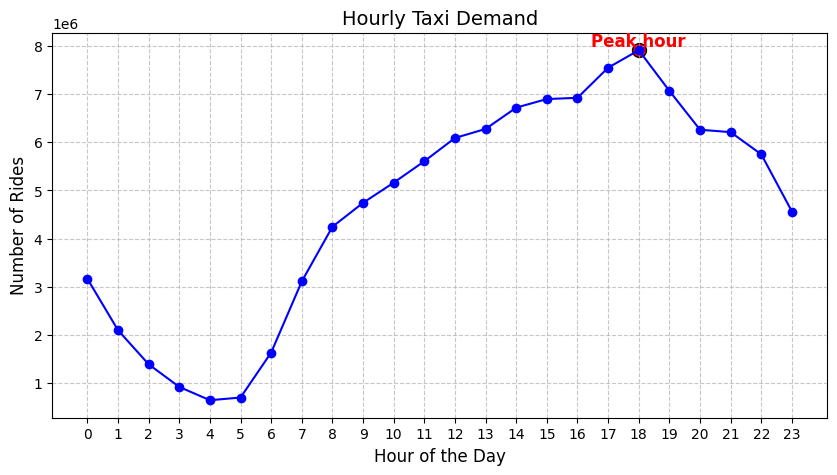

In [28]:
# 다시 시간순으로 정렬
hour_taxi = hour_taxi.orderBy('hour')
hour_taxi_pd = hour_taxi.toPandas()

max_count = hour_taxi_pd['count'].max()
peak_hour = hour_taxi_pd[hour_taxi_pd['count'] == max_count]['hour'].values

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(hour_taxi_pd['hour'], hour_taxi_pd['count'], marker='o', linestyle='-', color='b')

# 피크 시간대 강조 (빨간색 마커)
plt.scatter(peak_hour, [max_count] * len(peak_hour), color='red', s=100, label="Peak Hour", edgecolors='black')

# 하나의 피크 시간대에 텍스트 라벨 추가
plt.text(peak_hour, max_count, "Peak hour", fontsize=12, color='red', ha='center', va='bottom', fontweight='bold')

# 그래프 제목 및 레이블 추가
plt.title("Hourly Taxi Demand", fontsize=14)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)
plt.xticks(range(0, 24))  # 24시간 x축 표시
plt.grid(True, linestyle="--", alpha=0.7)

# 그래프 출력
plt.show()

Peak hour은 18:00임을 확인할 수 있다.

### Weather Condition Analysis:

Correlate trip demand with weather conditions (e.g., temperature, precipitation).
Present the findings on how different weather conditions affect the number of trips.
Use statistical methods to validate the findings.

뉴욕의 날씨 데이터 셋은 "https://open-meteo.com/en/docs/historical-weather-api"를 활용하여 추출하였다.

In [35]:
file_path = "/Users/admin/Desktop/GitHub/data_engineering_course_materials/missions/W4/NewYork_weather.csv"

df_weather = spark.read.option("header", True).csv(file_path)

df_weather.printSchema()

df_weather.show()

root
 |-- time: string (nullable = true)
 |-- temperature_2m (°C): string (nullable = true)
 |-- precipitation (mm): string (nullable = true)
 |-- rain (mm): string (nullable = true)
 |-- weather_code (wmo code): string (nullable = true)

+----------------+-------------------+------------------+---------+-----------------------+
|            time|temperature_2m (°C)|precipitation (mm)|rain (mm)|weather_code (wmo code)|
+----------------+-------------------+------------------+---------+-----------------------+
|2022-01-01T00:00|                7.7|              0.00|     0.00|                      3|
|2022-01-01T01:00|                7.8|              0.00|     0.00|                      3|
|2022-01-01T02:00|                7.5|              0.00|     0.00|                      3|
|2022-01-01T03:00|                7.4|              0.10|     0.10|                     51|
|2022-01-01T04:00|                7.6|              0.10|     0.10|                     51|
|2022-01-01T05:00|       

In [30]:
# Weather_code에 대응하는 날씨 맵핑
weather_mapping = {
    "0": "Clear sky",
    "1": "Partly cloudy", "2": "Partly cloudy", "3": "Partly cloudy",
    "45": "Fog", "48": "Fog",
    "51": "Drizzle (light)", "53": "Drizzle (moderate)", "55": "Drizzle (heavy)",
    "56": "Freezing drizzle (light)", "57": "Freezing drizzle (dense)",
    "61": "Rain (slight)", "63": "Rain (moderate)", "65": "Rain (heavy)",
    "66": "Freezing rain (light)", "67": "Freezing rain (heavy)",
    "71": "Snow (slight)", "73": "Snow (moderate)", "75": "Snow (heavy)",
    "77": "Snow grains",
    "80": "Rain showers", "81": "Rain showers", "82": "Rain showers",
    "85": "Snow showers", "86": "Snow showers",
    "95": "Thunderstorm (slight or moderate)",
    "96": "Thunderstorm with hail", "99": "Thunderstorm with hail"
}

# 매핑 적용
df_weather = df_weather.replace(weather_mapping, subset=["weather_code (wmo code)"])

# weather_condition으로 컬럼 이름 변경
df_weather = df_weather.withColumnRenamed("weather_code (wmo code)", "weather_condition")

# 결과 확인
df_weather.show()

+----------------+-------------------+------------------+---------+------------------+
|            time|temperature_2m (°C)|precipitation (mm)|rain (mm)| weather_condition|
+----------------+-------------------+------------------+---------+------------------+
|2022-01-01T00:00|                7.7|              0.00|     0.00|     Partly cloudy|
|2022-01-01T01:00|                7.8|              0.00|     0.00|     Partly cloudy|
|2022-01-01T02:00|                7.5|              0.00|     0.00|     Partly cloudy|
|2022-01-01T03:00|                7.4|              0.10|     0.10|   Drizzle (light)|
|2022-01-01T04:00|                7.6|              0.10|     0.10|   Drizzle (light)|
|2022-01-01T05:00|                8.2|              1.10|     1.10|   Drizzle (heavy)|
|2022-01-01T06:00|                8.4|              1.10|     1.10|   Drizzle (heavy)|
|2022-01-01T07:00|                8.0|              0.50|     0.50|Drizzle (moderate)|
|2022-01-01T08:00|                9.1|     

In [32]:
# Weather 데이터 `time`을 timestamp로 변환
df_weather = df_weather.withColumn("time", F.to_timestamp(F.col("time"), "yyyy-MM-dd'T'HH:mm"))

# Weather 데이터에서 `날짜(date)`와 `시간(hour)` 컬럼 생성
df_weather = df_weather.withColumn("date", F.date_format(F.col("time"), "yyyy-MM-dd"))
df_weather = df_weather.withColumn("hour", F.hour(col("time")))

# Taxi 데이터와 Weather 데이터 Join (date, hour 기준)
taxi_weather_df = taxi_df.join(df_weather, ["date", "hour"], "left")

# 결과 확인
taxi_weather_df.select("tpep_pickup_datetime", "temperature_2m (°C)", "precipitation (mm)", "rain (mm)", "weather_condition").show(10)

+--------------------+-------------------+------------------+---------+-----------------+
|tpep_pickup_datetime|temperature_2m (°C)|precipitation (mm)|rain (mm)|weather_condition|
+--------------------+-------------------+------------------+---------+-----------------+
| 2023-06-01 00:08:48|               13.7|              0.00|     0.00|        Clear sky|
| 2023-06-01 00:15:04|               13.7|              0.00|     0.00|        Clear sky|
| 2023-06-01 00:48:24|               13.7|              0.00|     0.00|        Clear sky|
| 2023-06-01 00:54:03|               13.7|              0.00|     0.00|        Clear sky|
| 2023-06-01 00:18:44|               13.7|              0.00|     0.00|        Clear sky|
| 2023-06-01 00:32:36|               13.7|              0.00|     0.00|        Clear sky|
| 2023-06-01 00:31:55|               13.7|              0.00|     0.00|        Clear sky|
| 2023-06-01 00:55:30|               13.7|              0.00|     0.00|        Clear sky|
| 2023-06-

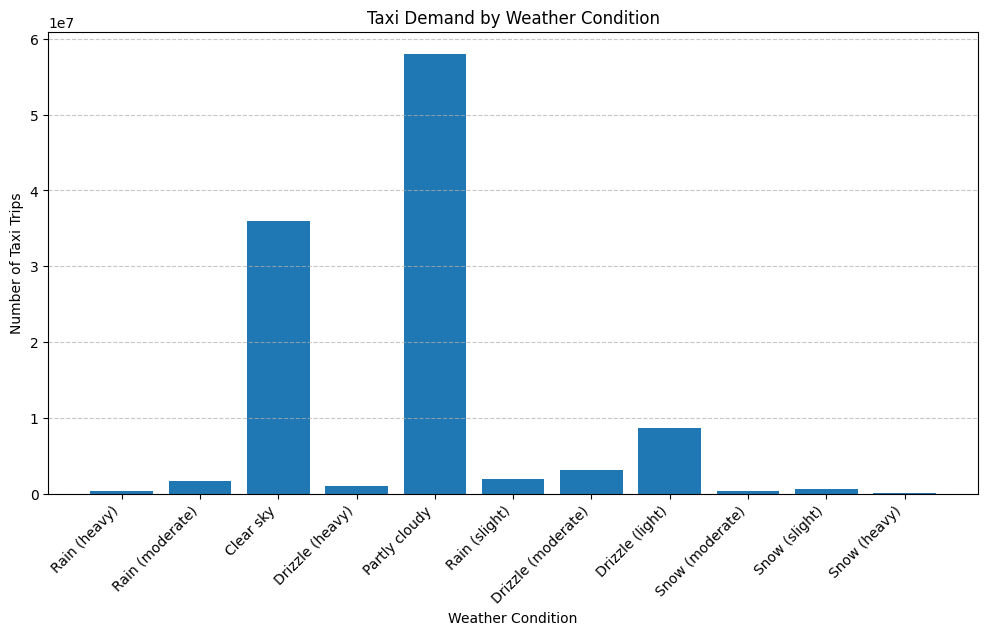

In [34]:
import matplotlib.pyplot as plt

# weather_condition별로 행 개수를 세서 택시 수요 계산
weather_demand = taxi_weather_df.groupBy("weather_condition").count().toPandas()

# 컬럼 이름 변경
weather_demand.columns = ["weather_condition", "trip_count"]

# 결측치 제거
weather_demand = weather_demand.dropna(subset=["weather_condition"])

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(weather_demand["weather_condition"], weather_demand["trip_count"])
plt.xlabel("Weather Condition")
plt.ylabel("Number of Taxi Trips")
plt.title("Taxi Demand by Weather Condition")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()

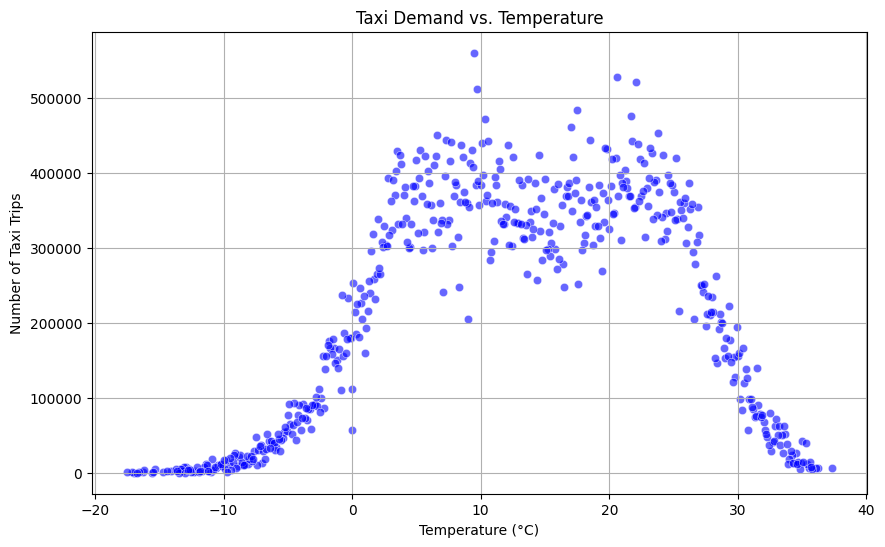

In [39]:
# 온도별 택시 호출 수 계산
taxi_temp_df = taxi_weather_df.groupBy("temperature_2m (°C)").agg(F.count("*").alias("trip_count"))

# 온도열을 다시 숫자형으로 변환
taxi_temp_df = taxi_temp_df.withColumn("temperature_2m (°C)", F.col("temperature_2m (°C)").cast("float"))

# Pandas 변환
taxi_temp_df_pd = taxi_temp_df.toPandas()

# 결측치 제거
taxi_temp_df_pd = taxi_temp_df_pd.dropna(subset=["temperature_2m (°C)"])

# 온도 vs 택시 호출 수 시각화
plt.figure(figsize=(10,6))
sns.scatterplot(data=taxi_temp_df_pd, x="temperature_2m (°C)", y="trip_count", color="blue", alpha=0.6)
plt.xlabel("Temperature (°C)")
plt.ylabel("Number of Taxi Trips")
plt.title("Taxi Demand by Temperature")
plt.grid(True)
plt.show()

In [54]:
# 상관분석 열 추출
temp_values = taxi_temp_df_pd["temperature_2m (°C)"].astype(float)
trip_values = taxi_temp_df_pd["trip_count"].astype(float)

# Pearson 상관계수 계산
temp_correlation, temp_p_value = pearsonr(temp_values, trip_values)

# 결과 출력
print(f"Pearson Correlation: {temp_correlation:.4f}, P-value: {temp_p_value:.4f}")

# 결과 해석
if temp_p_value < 0.05:
    temp_result = "유의미한 상관 관계 있음"
    print("온도와 택시 수요 사이에 통계적으로 유의미한 상관관계가 있습니다.")
else:
    temp_result = "유의미한 상관 관계 없음"
    print("온도와 택시 수요 사이의 관계는 유의미하지 않습니다.")

Pearson Correlation: 0.3252, P-value: 0.0000
온도와 택시 수요 사이에 통계적으로 유의미한 상관관계가 있습니다.


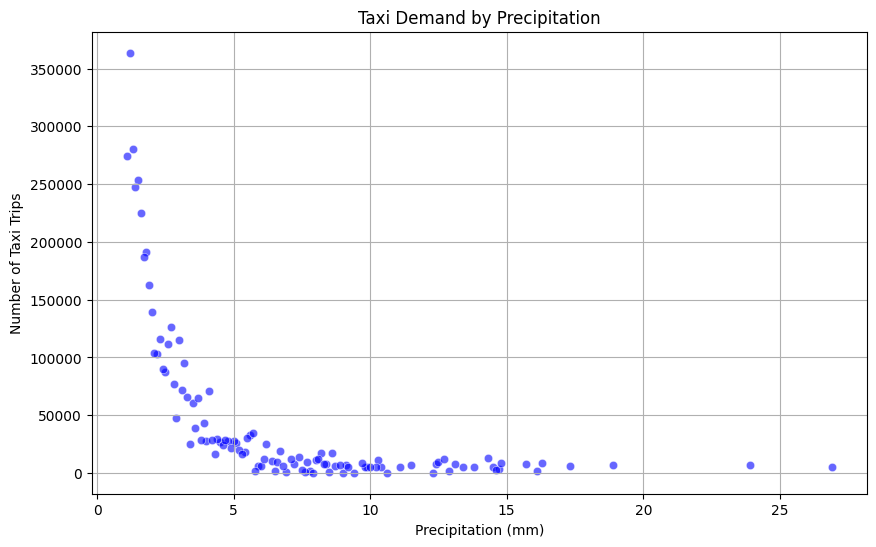

In [44]:
# 강수량별 택시 호출 수 계산
taxi_precip_df = taxi_weather_df.groupBy("precipitation (mm)").agg(F.count("*").alias("trip_count"))

# 강수량 열을 숫자형(float)으로 변환
taxi_precip_df = taxi_precip_df.withColumn("precipitation (mm)", F.col("precipitation (mm)").cast("float"))

# 의미있는 시각화를 위해 강수량이 1mm 이상인 경우에 한에 분석을 진행
taxi_precip_df = taxi_precip_df.filter(F.col("precipitation (mm)") > 1)

# Pandas 변환
taxi_precip_df_pd = taxi_precip_df.toPandas()

# 결측치 제거
taxi_precip_df_pd = taxi_precip_df_pd.dropna(subset=["precipitation (mm)"])

# 강수량 vs 택시 호출 수 시각화
plt.figure(figsize=(10,6))
sns.scatterplot(data=taxi_precip_df_pd, x="precipitation (mm)", y="trip_count", color="blue", alpha=0.6)

plt.xlabel("Precipitation (mm)")
plt.ylabel("Number of Taxi Trips")
plt.title("Taxi Demand by Precipitation")
plt.grid(True)
plt.show()

In [56]:
# 상관분석 열 추출
precip_values = taxi_precip_df_pd["precipitation (mm)"]
trip_values = taxi_precip_df_pd["trip_count"]

# Pearson 상관계수 계산
precip_correlation, precip_p_value = pearsonr(precip_values, trip_values)

# 결과 출력
print(f"📌 Pearson Correlation: {precip_correlation:.4f}, P-value: {precip_p_value:.4f}")

# 결과 해석
if precip_p_value < 0.05:
    precip_result = "유의미한 상관 관계 있음"
    print("강수량과 택시 수요 사이에 통계적으로 유의미한 상관관계가 있습니다.")
else:
    precip_result = "유의미한 상관 관계 없음"
    print("강수량과 택시 수요 사이의 관계는 유의미하지 않습니다.")

📌 Pearson Correlation: -0.5726, P-value: 0.0000
강수량과 택시 수요 사이에 통계적으로 유의미한 상관관계가 있습니다.


In [62]:
# 온도/강수량과 택시 수요 관계의 통계량을 데이터 프레임으로 저장.
correlation_results = pd.DataFrame({
    "Variable": ["Temperature (°C)", "Precipitation (mm)"],
    "Pearson Correlation": [temp_correlation, precip_correlation],
    "P-value": [temp_p_value, precip_p_value],
    "Significance": [temp_result, precip_result]
})

correlation_results_spark = spark.createDataFrame(correlation_results)

# csv 파일 저장
correlation_results_spark.write.csv("output/weather_analysis", header=True, mode="overwrite")